In [1]:
import os
import sys
_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)
from itertools import product

import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

from streampuncher import StreamPuncher

Parameters:
- Impact site $\phi_1$
- Impact time $\tau$
- Impact parameter $b$
- Cylindrical angle $\psi$
- $v_z$, $v_\psi$ ($v_r=0$)
- Subhalo parameters $M$, $r_s$

In [2]:
H = gp.NFWPotential.from_circular_velocity(v_c=220*u.km/u.s, r_s=18*u.kpc, 
                                           units=galactic)
H = gp.Hamiltonian(H)

In [3]:
df = gd.FardalStreamDF(lead=True, trail=False)
prog_pot = gp.PlummerPotential(2e4*u.Msun, b=5*u.pc, units=galactic)
gen = gd.MockStreamGenerator(df, H, progenitor_potential=prog_pot)

In [4]:
w0 = gd.PhaseSpacePosition([-18., 0, 0]*u.kpc,
                           [0, 220, 0]*u.km/u.s)

In [5]:
stream, _ = gen.run(prog_w0=w0,
                    prog_mass=2e4*u.Msun, 
                    dt=-0.2, t1=0, t2=-6*u.Gyr, n_particles=1)

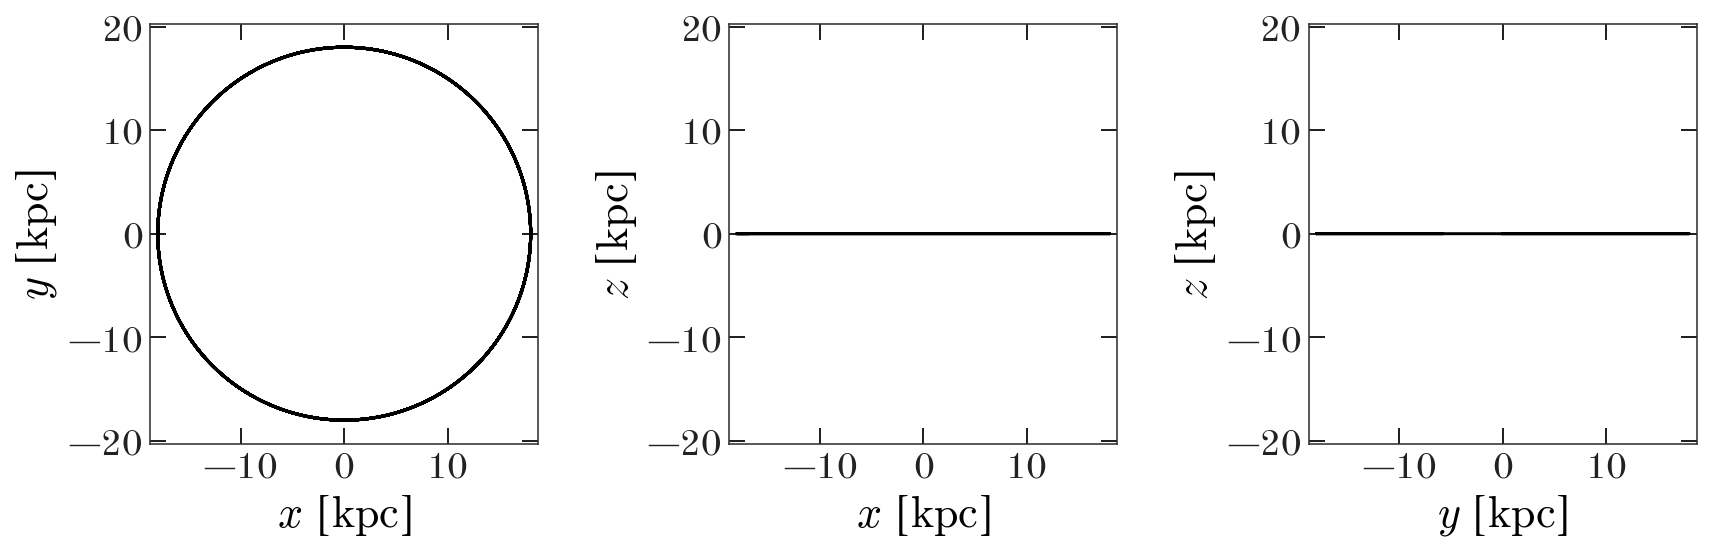

In [6]:
orbit = H.integrate_orbit(w0, dt=0.5, n_steps=10000)
_ = orbit.plot()

(2, 6)

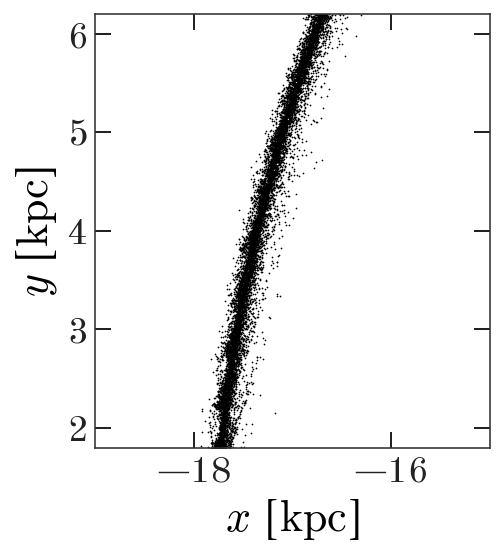

In [7]:
fig = stream.plot(components=['x', 'y'], alpha=1, lw=0, s=3)
ax = fig.axes[0]
ax.set_xlim(-17.-2, -17.+2)
ax.set_ylim(4-2, 4+2)

In [8]:
impact_site_mask = ((stream.x > -18*u.kpc) &
                    (stream.x < -16*u.kpc) &
                    (stream.y > 4.6*u.kpc) & 
                    (stream.y < 4.7*u.kpc))
impact_today_w0 = gd.PhaseSpacePosition(
    pos=stream[impact_site_mask].xyz.mean(axis=1),
    vel=stream[impact_site_mask].v_xyz.mean(axis=1))

In [9]:
mask = ((stream.x > (impact_today_w0.x - 3*u.kpc)) & 
        (stream.x < (impact_today_w0.x + 3*u.kpc)) &
        (stream.y > (impact_today_w0.y - 4*u.kpc)) & 
        (stream.y < (impact_today_w0.y + 4*u.kpc)))

# idx = np.random.choice(mask.sum(), size=16384, replace=False)
idx = np.random.choice(mask.sum(), size=8192, replace=False)
sub_stream = stream[mask][idx]

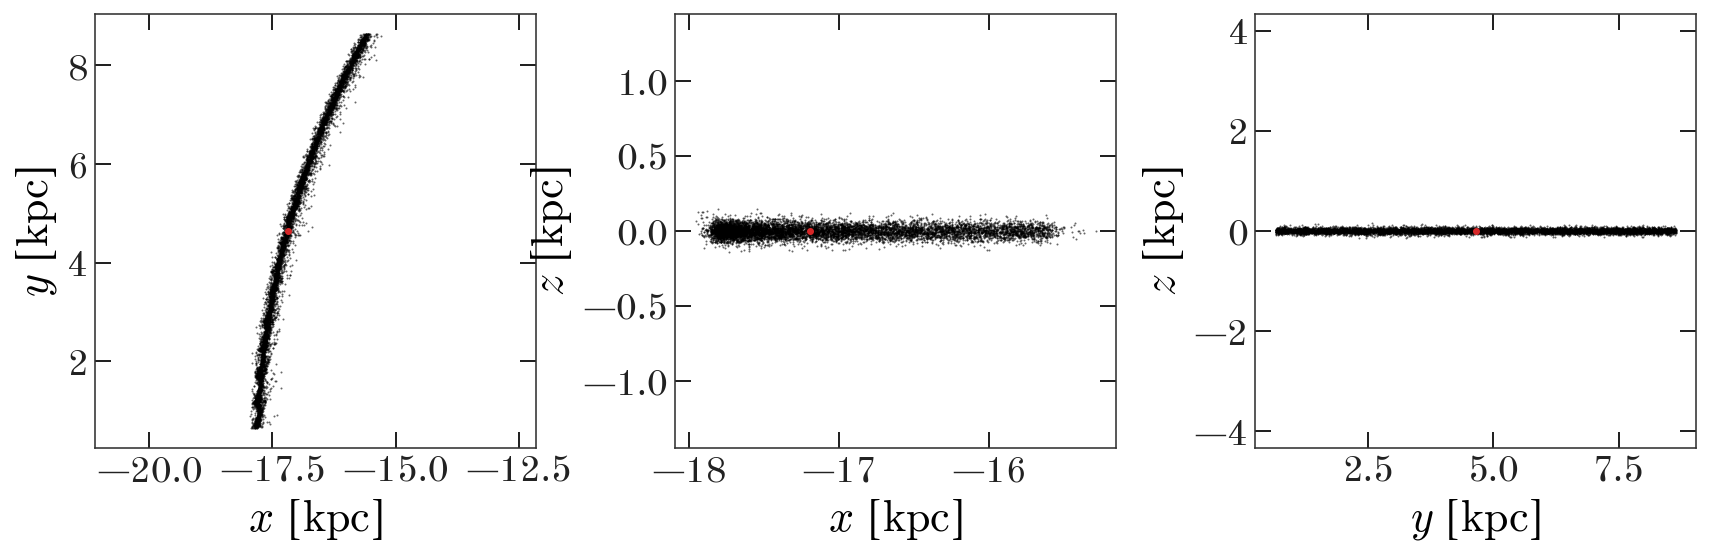

In [10]:
fig = sub_stream.plot(alpha=0.6, s=4, lw=0)
_ = impact_today_w0.plot(color='tab:red', zorder=100, axes=fig.axes)

In [11]:
puncher = StreamPuncher(sub_stream, impact_today_w0, 
                        external_potential=H.potential)

In [12]:
# perturber_potential = gp.HernquistPotential(m=5e6*u.Msun, c=10*u.pc, units=galactic)
perturber_potential = gp.NFWPotential(m=5e6*u.Msun, r_s=15*u.pc, units=galactic)

In [13]:
%%time
perturbed_stream_orbits = puncher.run(
    b=15*u.pc, psi=0*u.deg, vz=0*u.km/u.s, vpsi=-100*u.km/u.s, 
    tau=-500*u.Myr, perturber_potential=perturber_potential,
    dt=0.5*u.Myr, impact_dist_buffer=2*u.kpc)

CPU times: user 7.16 s, sys: 229 ms, total: 7.39 s
Wall time: 7.38 s


In [14]:
%%time
perturbed_stream_orbits = puncher.run(
    b=15*u.pc, psi=0*u.deg, vz=0*u.km/u.s, vpsi=-100*u.km/u.s, 
    tau=-500*u.Myr, perturber_potential=perturber_potential,
    dt=0.5*u.Myr, impact_dist_buffer=2*u.kpc)

CPU times: user 4.91 s, sys: 98.4 ms, total: 5.01 s
Wall time: 5 s


In [15]:
%load_ext line_profiler

In [16]:
%lprun -f StreamPuncher.run puncher.run(b=15*u.pc, psi=0*u.deg, vz=0*u.km/u.s, vpsi=-100*u.km/u.s, tau=-500*u.Myr, perturber_potential=perturber_potential, dt=0.5*u.Myr, impact_dist_buffer=2*u.kpc)
# %lprun -f gd.DirectNBody.__init__ puncher.run(b=15*u.pc, psi=0*u.deg, vz=0*u.km/u.s, vpsi=-100*u.km/u.s, tau=-500*u.Myr, perturber_potential=perturber_potential, dt=0.5*u.Myr, impact_dist_buffer=2*u.kpc)

In [15]:
def to_fixed_coords(stream, origin):    
    L = origin.angular_momentum()
    v = origin.v_xyz
    
    new_x = v / np.linalg.norm(v, axis=0)
    new_z = L / np.linalg.norm(L, axis=0)
    new_y = -np.cross(new_x, new_z)
    R = np.stack((new_x, new_y, new_z))  # rotation matrix
    
    tmp = (stream.pos - origin.pos).transform(R)
    
    return gd.PhaseSpacePosition(tmp, stream.vel)

In [16]:
# derp1 = H.integrate_orbit(sub_stream, dt=-0.5*u.Myr, n_steps=1000)
# derp2 = H.integrate_orbit(impact_today_w0, dt=-0.5*u.Myr, n_steps=1000)
# test = to_fixed_coords(derp1[-1], derp2[-1])
# _ = test.plot()

In [18]:
synced_impact_site = H.integrate_orbit(impact_today_w0, 
                                       t=perturbed_stream_orbits.t[::-1])[::-1]
assert np.allclose(synced_impact_site.t, perturbed_stream_orbits.t)

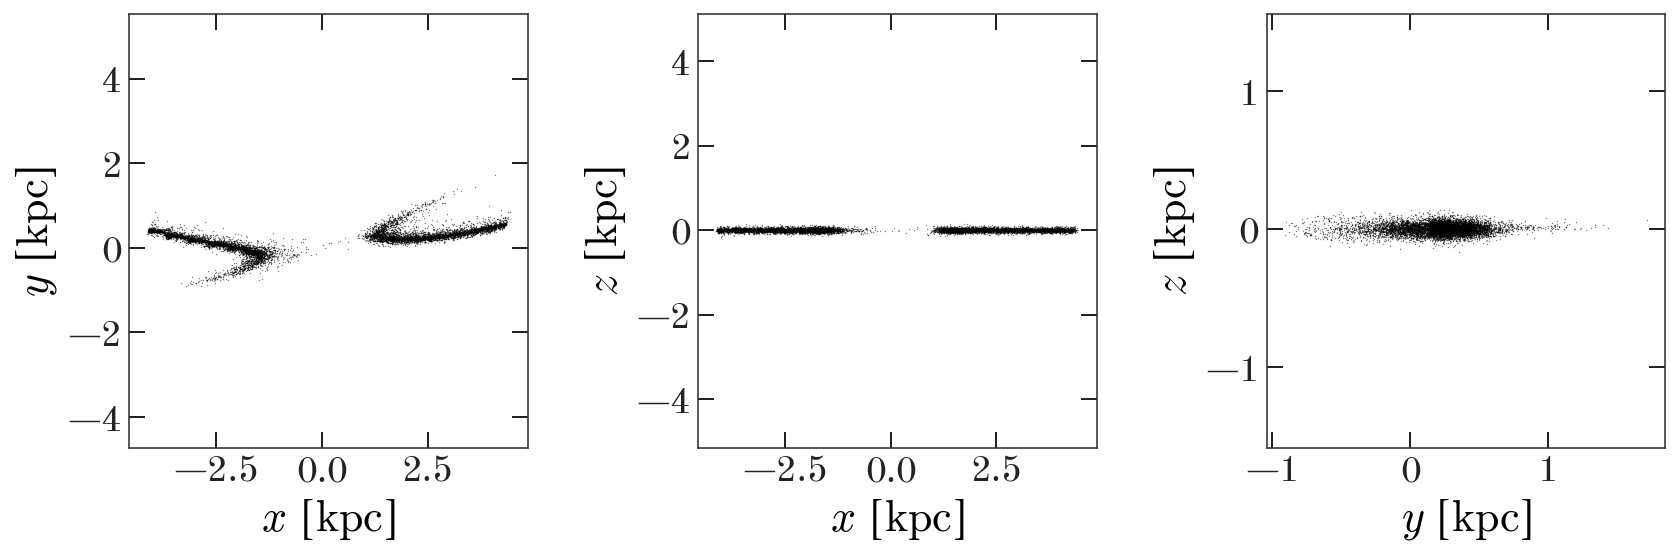

In [19]:
test = to_fixed_coords(perturbed_stream_orbits[-1, 1:], synced_impact_site[-1])
_ = test.plot(s=2, lw=0, alpha=0.5)

---

## Movies!

In [17]:
from matplotlib.animation import FuncAnimation

In [99]:
def animate_impact(stream_orbits, synced_site_orbit, impact_time, frame_step=1):
    assert np.allclose(stream_orbits.t, synced_site_orbit.t)
        
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                             sharey=True, constrained_layout=True)
    
    for ax in axes:
        ax.set_aspect('equal')

    style = dict(marker='o', mew=0, ls='none', ms=1, alpha=0.75)
    line1, = axes[0].plot([], [], **style)
    line2, = axes[1].plot([], [], **style)

    subhalo_line1, = axes[0].plot([], [], 
                                  marker='o', color='tab:red', ls='none')
    subhalo_line2, = axes[1].plot([], [], 
                                  marker='o', color='tab:red', ls='none')
    
    lim = 4
    axes[0].set_xlim(-lim, lim)
    axes[0].set_ylim(-lim, lim)

    axes[1].set_xlim(-lim, lim)
    axes[1].set_ylim(-lim, lim)
    
    axes[0].set_xlabel('$x$', fontsize=30)
    axes[0].set_ylabel('$y$', fontsize=30)
    
    axes[1].set_xlabel('$y$', fontsize=30)
    axes[1].set_ylabel('$z$', fontsize=30)

    def animate(i):
        tmp = to_fixed_coords(stream_orbits[i], synced_impact_site[i])
        
        xyz = tmp.xyz[:, 1:]
        line1.set_data(xyz.value[0], xyz.value[1])
        line2.set_data(xyz.value[0], xyz.value[2])

        perturber_xyz = tmp.xyz[:, 0]
        if np.abs(stream_orbits.t[i] - impact_time) < 10*u.Myr:
            subhalo_line1.set_data(perturber_xyz.value[0], 
                                   perturber_xyz.value[1])
            subhalo_line2.set_data(perturber_xyz.value[0], 
                                   perturber_xyz.value[2])
        else:
            subhalo_line1.set_data(999, 999)
            subhalo_line2.set_data(999, 999)

        return line1, line2, subhalo_line1, subhalo_line2 

    ani = FuncAnimation(fig, animate, 
                        frames=np.arange(0, stream_orbits.ntimes, frame_step),
                        interval=40, blit=True)
    return ani

In [102]:
b = 15*u.pc
tau = -1*u.Gyr
dt = 0.25*u.Myr

for psi, vz, vpsi in product(np.arange(0, 360, 45)*u.deg,
                             [-200, -100, 100, 200]*u.km/u.s,
                             np.arange(-200, 200+1, 100)*u.km/u.s):
    
    filename = f'psi{psi.value:.0f}_vz{vz.value:.0f}_vp{vpsi.value:.0f}'
    file_path = f'../movies/stream/{filename}.mp4'
    # if os.path.exists(file_path):
    #     continue
    
    if not os.path.exists(f'../cache/{filename}.hdf5'):
        perturbed_stream_orbits = impact_stream(
            perturber_potential, 
            sub_stream, H.potential,
            b=b, 
            psi=psi, 
            vz=vz, 
            vpsi=vpsi, 
            tau=tau,
            impact_site_w0=impact_today_w0,
            dt=dt, t_today=0*u.Myr, 
            save_orbits=True)
        
        perturbed_stream_orbits.to_hdf5(f'../cache/{filename}.hdf5')
    
    else:
        perturbed_stream_orbits = gd.Orbit.from_hdf5(f'../cache/{filename}.hdf5')
    
    synced_impact_site = H.integrate_orbit(
        impact_today_w0, t=perturbed_stream_orbits.t[::-1])[::-1]
    
    anim = animate_impact(perturbed_stream_orbits, 
                          synced_impact_site,
                          impact_time=tau, frame_step=4)
    anim.save(file_path, dpi=250)
    del anim
    
#     rot_perturbed_stream = gd.PhaseSpacePosition(perturbed_stream.data.transform(M))
    
#     # ---
    
#     style = dict(marker='o', ls='none', alpha=0.4, ms=1.)
#     fig, axes = plt.subplots(1, 2, figsize=(10, 5),
#                              constrained_layout=True)

#     ax = axes[0]
#     ax.plot(rot_perturbed_stream.x.to_value(u.kpc),
#             rot_perturbed_stream.y.to_value(u.kpc),
#             **style)

#     ax.set_xlim(r-3, r+3)
#     ax.set_ylim(-3, 3)
#     ax.set_xlabel('$x$')
#     ax.set_ylabel('$y$')

#     ax = axes[1]
#     ax.plot(rot_perturbed_stream.y.to_value(u.kpc),
#             rot_perturbed_stream.z.to_value(u.kpc),
#             **style)

#     ax.set_xlim(-3, 3)
#     ax.set_ylim(-3, 3)
#     ax.set_xlabel('$y$')
#     ax.set_ylabel('$z$')

#     fig.savefig(f'../plots/{filename}', dpi=250)
#     plt.close(fig)
    
#     break

/Users/apricewhelan/projects/gala/gala/dynamics/core.py:557: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(f)
/Users/apricewhelan/projects/gala/gala/dynamics/core.py:557: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(f)
/Users/apricewhelan/projects/gala/gala/dynamics/core.py:557: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) 

/Users/apricewhelan/projects/gala/gala/dynamics/core.py:557: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(f)
/Users/apricewhelan/projects/gala/gala/dynamics/core.py:557: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(f)
/Users/apricewhelan/projects/gala/gala/dynamics/core.py:557: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) 

/Users/apricewhelan/projects/gala/gala/dynamics/core.py:557: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(f)
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/Users/apricewhelan/projects/gala/gala/dynamics/core.py:557: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File

/Users/apricewhelan/projects/gala/gala/dynamics/core.py:557: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(f)
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/Users/apricewhelan/projects/gala/gala/dynamics/core.py:557: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File

Traceback (most recent call last):
  File "/Users/apricewhelan/anaconda/lib/python3.7/site-packages/matplotlib/animation.py", line 230, in saving
    yield self
  File "/Users/apricewhelan/anaconda/lib/python3.7/site-packages/matplotlib/animation.py", line 1156, in save
    writer.grab_frame(**savefig_kwargs)
  File "/Users/apricewhelan/anaconda/lib/python3.7/site-packages/matplotlib/animation.py", line 384, in grab_frame
    dpi=self.dpi, **savefig_kwargs)
  File "/Users/apricewhelan/anaconda/lib/python3.7/site-packages/matplotlib/figure.py", line 2180, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/Users/apricewhelan/anaconda/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 2082, in print_figure
    **kwargs)
  File "/Users/apricewhelan/anaconda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 446, in print_raw
    fh.write(renderer._renderer.buffer_rgba())
KeyboardInterrupt

During handling of the above exception, another excepti

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '3000x1500', '-pix_fmt', 'rgba', '-r', '25.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '../movies/stream/psi45_vz200_vp0.mp4']' returned non-zero exit status 255.

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f9b515d7bf8> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f9b51661840> (for post_execute):


KeyboardInterrupt: 

--- 

## OLD! 

---

In [774]:
end1 = coord.CartesianRepresentation(np.mean(stream[mask][-10:].xyz, axis=1))
end2 = coord.CartesianRepresentation(np.mean(stream[mask][:10].xyz, axis=1))
end1 = coord.SkyCoord(end1, frame=galcen_frame_nosunv).transform_to(coord.ICRS)
end2 = coord.SkyCoord(end2, frame=galcen_frame_nosunv).transform_to(coord.ICRS)

frame = gc.GreatCircleICRSFrame.from_endpoints(end1, end2)

In [775]:
stream_coords = sub_stream.to_coord_frame(frame, 
                                          galactocentric_frame=galcen_frame_nosunv)

In [776]:
np.std(stream_coords.phi2.degree)  # should be ~0.3–0.4 deg

0.23431511523465906

(-2, 2)

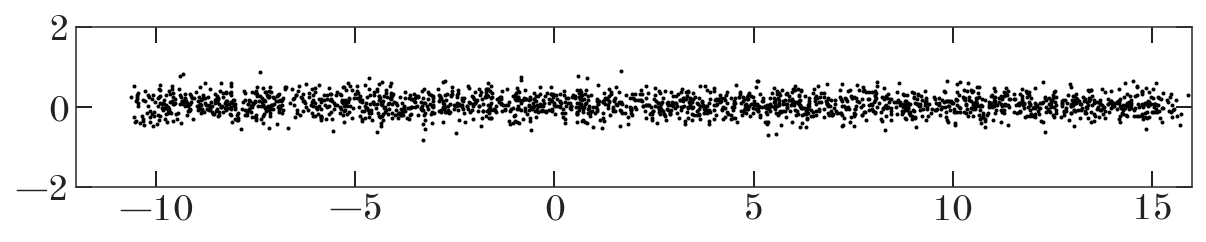

In [777]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.scatter(stream_coords.phi1.degree, stream_coords.phi2.degree, 
           lw=0, s=4)
ax.set_aspect('equal')
ax.set_xlim(-12, 16)
ax.set_ylim(-2, 2)

Choose the impact site to be at phi1=2.5º

In [778]:
impact_site_mask = (np.abs(stream_coords.phi1.degree-2.5) < 0.5)
impact_today_w0 = gd.PhaseSpacePosition(
    pos=sub_stream[impact_site_mask].xyz.mean(axis=1),
    vel=sub_stream[impact_site_mask].v_xyz.mean(axis=1))

Rewind this part of the stream to the time of impact:

In [1096]:
impact_time = -4*u.Myr
impact_past = H.integrate_orbit(impact_today_w0, dt=-0.5, t1=0, t2=impact_time)
impact_past_w0 = impact_past[-1]
impact_past_t0 = impact_past.t[-1]

In [1097]:
tmp_w0 = impact_past_w0

L = tmp_w0.angular_momentum()
new_z = tmp_w0.v_xyz / np.linalg.norm(tmp_w0.v_xyz, axis=0)
new_x = L / np.linalg.norm(L, axis=0)
new_y = -np.cross(new_x, new_z)

origin = tmp_w0.data.without_differentials()
R = np.stack((new_x, new_y, new_z))

In [1098]:
perturber_mass = 5e6 * u.Msun
perturber_size = 10 * u.pc
# perturber_pot = gp.NFWPotential(m=perturber_mass/(np.log(2) - 0.5), 
#                                 r_s=perturber_size, 
#                                 units=galactic)
perturber_pot = gp.HernquistPotential(m=2 * perturber_mass, 
                                      c=perturber_size, 
                                      units=galactic)

In [1099]:
b = 15 * u.pc
perturber_rep = coord.CylindricalRepresentation(rho=b, 
                                                phi=300*u.deg, 
                                                z=0*u.pc) # Fixed
perturber_rep = perturber_rep.with_differentials(
    coord.CylindricalDifferential(d_rho=0*u.km/u.s, # Fixed
                                  d_phi=(-50*u.km/u.s/b).to(u.rad/u.Myr, u.dimensionless_angles()), 
                                  d_z=-150*u.km/u.s))
perturber_rep = perturber_rep.represent_as(
    coord.CartesianRepresentation, coord.CartesianDifferential)
perturber_rep = perturber_rep.transform(R.T)

pos = perturber_rep.without_differentials() + impact_past_w0.pos
vel = perturber_rep.differentials['s'] + impact_past_w0.vel

perturber_past_w0 = gd.PhaseSpacePosition(pos, vel)

In [1100]:
# dx = np.random.normal([0,0,0], 15.)*u.pc
# perturber_v = np.random.normal(0, 200., size=3)*u.km/u.s
# dx = 15*u.pc * random_unit_vector()
# dv = 250*u.km/u.s * random_unit_vector()

dx = impact_past_w0.xyz - perturber_past_w0.xyz
dv = impact_past_w0.v_xyz - perturber_past_w0.v_xyz
np.linalg.norm(dx).to(u.pc), np.linalg.norm(dv).to(u.km/u.s)

(<Quantity 15. pc>, <Quantity 158.11388301 km / s>)

In [1101]:
perturber_today_w0 = H.integrate_orbit(perturber_past_w0, 
                                       dt=0.5, t1=impact_past_t0, t2=0)[-1]

In [1102]:
w0 = gd.combine((perturber_today_w0, 
                 gd.PhaseSpacePosition(sub_stream.pos,
                                       sub_stream.vel,
                                       frame=perturber_today_w0.frame)))

tmp = H.integrate_orbit(w0, dt=-0.5*u.Myr, t1=0, t2=1.5*impact_time)
w0_past = tmp[-1]
t0_past = tmp.t[-1]

In [1108]:
ppots = [perturber_pot] + [None] * sub_stream.shape[0]
nbody = gd.DirectNBody(w0_past, particle_potentials=ppots, 
                       units=galactic, external_potential=H.potential)
orbits = nbody.integrate_orbit(t1=t0_past, t2=0., dt=0.4*u.Myr)

In [1104]:
hit_stream_coords = orbits[-1].to_coord_frame(frame, 
                                              galactocentric_frame=galcen_frame_nosunv)

perturber_orbit_coords = orbits[:, 0].to_coord_frame(
    frame, galactocentric_frame=galcen_frame_nosunv)

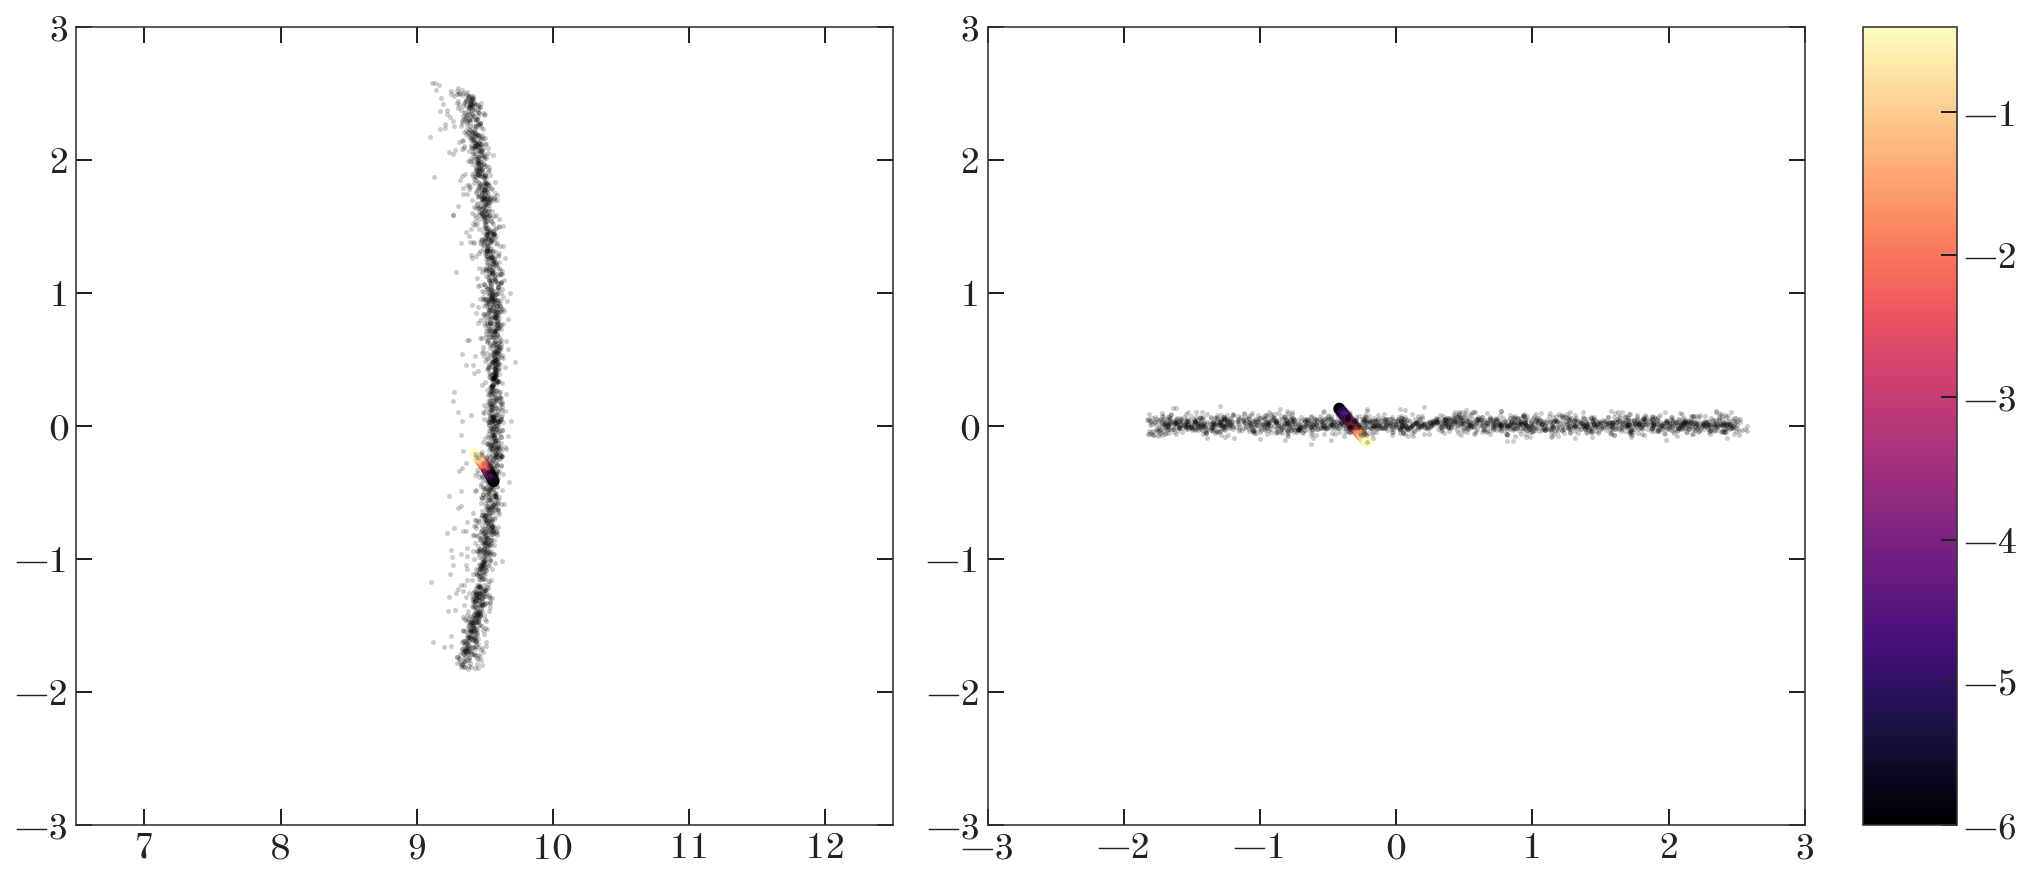

In [1105]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6),
                         constrained_layout=True)

ax = axes[0]
ax.plot(hit_stream_coords.data.x,
        hit_stream_coords.data.y,
        marker='o', ls='none', alpha=0.2, ms=2.5)

ax.scatter(perturber_orbit_coords.data.x,
           perturber_orbit_coords.data.y,
           c=orbits.t.value)

ax.set_xlim(9.5-3, 9.5+3)
ax.set_ylim(-3, 3)

ax = axes[1]
ax.plot(hit_stream_coords.data.y,
        hit_stream_coords.data.z,
        marker='o', ls='none', alpha=0.2, ms=2.5)

cs = ax.scatter(perturber_orbit_coords.data.y,
                perturber_orbit_coords.data.z,
                c=orbits.t.value)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

fig.colorbar(cs, ax=axes)